In [1]:
pip install mlxtend

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from scipy.spatial import distance
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering as hclust
from scipy.cluster.hierarchy import dendrogram, ward
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules 

## Classification Algorithms

### Data Preprocessing

In [3]:
# read ratings.csv into ratings
ratings = pd.read_csv('C:/movielens_20m/rating.csv')

In [4]:
# check for the null values in ratings
null_ratings = ratings.isnull().sum()
null_ratings

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [5]:
# drop the columns with names userId and timestamp
ratings.drop(columns=['userId', 'timestamp'], inplace=True)
#sort the ratings by rating and group by movieId
grouped_ratings = ratings.sort_values(by=['rating']).groupby('movieId')['rating'].mean()
# display the first 10 data of grouped_ratings
grouped_ratings.head(10)

movieId
1     3.921240
2     3.211977
3     3.151040
4     2.861393
5     3.064592
6     3.834930
7     3.366484
8     3.142049
9     3.004924
10    3.430029
Name: rating, dtype: float64

In [6]:
# read movie.csv into genres
genres = pd.read_csv('C:/movielens_20m/movie.csv')

In [7]:
# check for the null values in genres
null_genres = genres.isnull().sum()
null_genres

movieId    0
title      0
genres     0
dtype: int64

In [8]:
# drop columns genres and title, split the genres and join them together with movieId
seperated_genres = genres.drop(columns=['genres', 'title'], axis=1).join(genres.genres.str.get_dummies())
# display the first 10 data of seperated_genres
seperated_genres.head(10)

movieId  (no genres listed)  Action  Adventure  Animation  Children  \
0        1                   0       0          1          1         1   
1        2                   0       0          1          0         1   
2        3                   0       0          0          0         0   
3        4                   0       0          0          0         0   
4        5                   0       0          0          0         0   
5        6                   0       1          0          0         0   
6        7                   0       0          0          0         0   
7        8                   0       0          1          0         1   
8        9                   0       1          0          0         0   
9       10                   0       1          1          0         0   

   Comedy  Crime  Documentary  Drama  ...  Film-Noir  Horror  IMAX  Musical  \
0       1      0            0      0  ...          0       0     0        0   
1       0      0            0      0  ...          0       0     0        0   
2       1      0            0      0  ...          0       0     0        0   
3       1      0            0      1  ...          0       0     0        0   
4       1      0            0      0  ...          0       0     0        0   
5       0      1            0      0  ...          0       0     0        0   
6       1      0            0      0  ...          0       0     0        0   
7       0      0            0      0  ...          0       0     0        0   
8       0      0            0      0  ...          0       0     0        0   
9       0      0            0      0  ...          0       0     0        0   

   Mystery  Romance  Sci-Fi  Thriller  War  Western  
0        0        0       0         0    0        0  
1        0        0       0         0    0        0  
2        0        1       0         0    0        0  
3        0        1       0         0    0        0  
4        0        0       0         0    0        0  
5        0        0       0         1    0        0  
6        0        1       0         0    0        0  
7        0        0       0         0    0        0  
8        0        0       0         0    0        0  
9        0        0       0         1    0        0  

[10 rows x 21 columns]

In [9]:
# merge the seperated genres with the grouped ratings based on movieId
movie_ratings = seperated_genres.merge(grouped_ratings, on='movieId')
# display the first 10 data of movie_ratings
movie_ratings.head(10)

movieId  (no genres listed)  Action  Adventure  Animation  Children  \
0        1                   0       0          1          1         1   
1        2                   0       0          1          0         1   
2        3                   0       0          0          0         0   
3        4                   0       0          0          0         0   
4        5                   0       0          0          0         0   
5        6                   0       1          0          0         0   
6        7                   0       0          0          0         0   
7        8                   0       0          1          0         1   
8        9                   0       1          0          0         0   
9       10                   0       1          1          0         0   

   Comedy  Crime  Documentary  Drama  ...  Horror  IMAX  Musical  Mystery  \
0       1      0            0      0  ...       0     0        0        0   
1       0      0            0      0  ...       0     0        0        0   
2       1      0            0      0  ...       0     0        0        0   
3       1      0            0      1  ...       0     0        0        0   
4       1      0            0      0  ...       0     0        0        0   
5       0      1            0      0  ...       0     0        0        0   
6       1      0            0      0  ...       0     0        0        0   
7       0      0            0      0  ...       0     0        0        0   
8       0      0            0      0  ...       0     0        0        0   
9       0      0            0      0  ...       0     0        0        0   

   Romance  Sci-Fi  Thriller  War  Western    rating  
0        0       0         0    0        0  3.921240  
1        0       0         0    0        0  3.211977  
2        1       0         0    0        0  3.151040  
3        1       0         0    0        0  2.861393  
4        0       0         0    0        0  3.064592  
5        0       0         1    0        0  3.834930  
6        1       0         0    0        0  3.366484  
7        0       0         0    0        0  3.142049  
8        0       0         0    0        0  3.004924  
9        0       0         1    0        0  3.430029  

[10 rows x 22 columns]

In [10]:
# drop the movieId from movie_ratings
movie_ratings = movie_ratings.drop('movieId', 1)

In [11]:
# Convert the rating to discrete values
movie_ratings['scale'] = pd.cut(movie_ratings['rating'], 2, labels=['Poor', 'Excellent'])
# displat the first 10 data of movie_ratings
movie_ratings.head(10)

(no genres listed)  Action  Adventure  Animation  Children  Comedy  Crime  \
0                   0       0          1          1         1       1      0   
1                   0       0          1          0         1       0      0   
2                   0       0          0          0         0       1      0   
3                   0       0          0          0         0       1      0   
4                   0       0          0          0         0       1      0   
5                   0       1          0          0         0       0      1   
6                   0       0          0          0         0       1      0   
7                   0       0          1          0         1       0      0   
8                   0       1          0          0         0       0      0   
9                   0       1          1          0         0       0      0   

   Documentary  Drama  Fantasy  ...  IMAX  Musical  Mystery  Romance  Sci-Fi  \
0            0      0        1  ...     0        0        0        0       0   
1            0      0        1  ...     0        0        0        0       0   
2            0      0        0  ...     0        0        0        1       0   
3            0      1        0  ...     0        0        0        1       0   
4            0      0        0  ...     0        0        0        0       0   
5            0      0        0  ...     0        0        0        0       0   
6            0      0        0  ...     0        0        0        1       0   
7            0      0        0  ...     0        0        0        0       0   
8            0      0        0  ...     0        0        0        0       0   
9            0      0        0  ...     0        0        0        0       0   

   Thriller  War  Western    rating      scale  
0         0    0        0  3.921240  Excellent  
1         0    0        0  3.211977  Excellent  
2         0    0        0  3.151040  Excellent  
3         0    0        0  2.861393  Excellent  
4         0    0        0  3.064592  Excellent  
5         1    0        0  3.834930  Excellent  
6         0    0        0  3.366484  Excellent  
7         0    0        0  3.142049  Excellent  
8         0    0        0  3.004924  Excellent  
9         1    0        0  3.430029  Excellent  

[10 rows x 22 columns]

### 1. Decision Tree Classification

In [12]:
# let x = all data from movie ratings except rating and scale
x = movie_ratings.iloc[:, :-2]
# Let y = scale
y = movie_ratings.iloc[:,-1]

In [13]:
# split x and y into train test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(criterion='gini', max_depth=4, max_features=None, class_weight=None)
# build a decision tree classifier from the training set x and y
dtc.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=4)

In [15]:
# predict class value for x
dtc_pred = dtc.predict(x_test)
dtc_pred

array(['Excellent', 'Excellent', 'Excellent', ..., 'Excellent',
       'Excellent', 'Excellent'], dtype=object)

#### Plot Decision Tree

In [16]:
# display all the columns names of movie_ratings
movie_ratings.columns

Index(['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',
       'War', 'Western', 'rating', 'scale'],
      dtype='object')

In [17]:
from sklearn.tree import plot_tree

# let fn = feature names
fn = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 
                 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
# let cn = class names
cn = ['Poor', 'Excellent']

# plot the decision tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (100,100), dpi=300)
plot_tree(dtc, feature_names=fn, class_names=cn, filled=True)

# save the decision tree plot
fig.savefig('DecisionTree.png')

#### Confusion Matrix

In [18]:
# Confusion Matrix for Decision Tree Classification
from sklearn.metrics import confusion_matrix
cmDtc = confusion_matrix(y_test, dtc_pred)
cmDtc

array([[3923,  165],
       [1078,  183]], dtype=int64)

In [19]:
# Classification Report for Decision Tree Classification
print(classification_report(y_test, dtc_pred))

              precision    recall  f1-score   support

   Excellent       0.78      0.96      0.86      4088
        Poor       0.53      0.15      0.23      1261

    accuracy                           0.77      5349
   macro avg       0.66      0.55      0.55      5349
weighted avg       0.72      0.77      0.71      5349



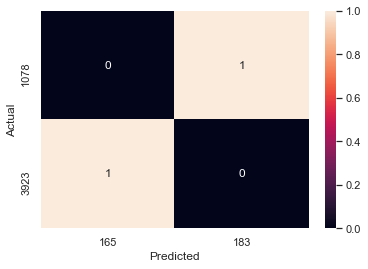

In [20]:
# plot Confusion Matrix for decision tree
df = pd.DataFrame(cmDtc, columns=['y_actual', 'y_predicted'])
confusion_matrix = pd.crosstab(df['y_actual'], df['y_predicted'], rownames=['Actual'], colnames=['Predicted'])
sb.heatmap(confusion_matrix, annot=True)
plt.show()

### 2. Logistic Regression

In [21]:
# let x = all data from movie ratings except rating and scale
x1 = movie_ratings.iloc[:, :-2]
# Let y = scale
y1 = movie_ratings.iloc[:,-1]

In [22]:
# split x and y into train test sets
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.2, random_state=42, stratify=y)

In [23]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

log = LogisticRegression(C=300.0)
# fit the model according to training set x and y
log.fit(x1_train, y1_train)

# predict class labels for samples in x
log_pred = log.predict(x1_test)
log_pred

array(['Excellent', 'Excellent', 'Excellent', ..., 'Excellent',
       'Excellent', 'Excellent'], dtype=object)

#### Confusion Matrix

In [24]:
# Confusion Matrix for Logistic Regression
from sklearn.metrics import confusion_matrix
cmLog = confusion_matrix(y1_test, log_pred)
cmLog

array([[3950,  138],
       [1090,  171]], dtype=int64)

In [25]:
# Classification Report for Logistic Regression
print(classification_report(y_test, log_pred))

              precision    recall  f1-score   support

   Excellent       0.78      0.97      0.87      4088
        Poor       0.55      0.14      0.22      1261

    accuracy                           0.77      5349
   macro avg       0.67      0.55      0.54      5349
weighted avg       0.73      0.77      0.71      5349



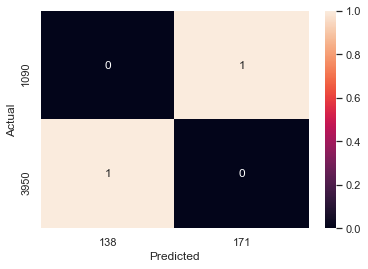

In [26]:
# plot Confusion Matrix for Logistic Regression
df = pd.DataFrame(cmLog, columns=['y_actual', 'y_predicted'])
confusion_matrix = pd.crosstab(df['y_actual'], df['y_predicted'], rownames=['Actual'], colnames=['Predicted'])
sb.heatmap(confusion_matrix, annot=True)
plt.show()

### 3. Support Vector Machine

In [83]:
# Support Vector Machine
from sklearn.svm import SVC

# change the particular scales to particular numbers
def scale_to_number(scale):
    if scale == 'Poor':
        return 0
    if scale == 'Excellent':
        return 1

# let x2 = action and fantasy from movie ratings
x2 = movie_ratings.iloc[:, :-2]
# let y2 = scale in number 
y2 = np.array([scale_to_number(scale) for scale in movie_ratings['scale']])

In [84]:
svc = SVC(kernel='linear', C=1000.0)

x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=0.2, random_state=42)

svc.fit(x2_train, y2_train)
svc_pred = svc.predict(x2_test)
svc_pred

array([1, 1, 1, ..., 1, 1, 1])

#### Confusion Matrix

In [85]:
# Confusion Matrix for SVM
from sklearn.metrics import confusion_matrix
cmSvc = confusion_matrix(y2_test, svc_pred)
cmSvc

array([[   0, 1275],
       [   0, 4074]], dtype=int64)

In [86]:
# Classification Report for SVM
print(classification_report(y2_test, svc_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1275
           1       0.76      1.00      0.86      4074

    accuracy                           0.76      5349
   macro avg       0.38      0.50      0.43      5349
weighted avg       0.58      0.76      0.66      5349



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


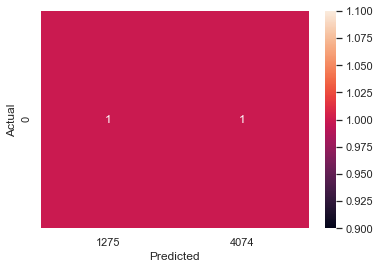

In [87]:
# plot Confusion Matrix for SVM
df = pd.DataFrame(cmSvc, columns=['y_actual', 'y_predicted'])
confusion_matrix = pd.crosstab(df['y_actual'], df['y_predicted'], rownames=['Actual'], colnames=['Predicted'])
sb.heatmap(confusion_matrix, annot=True)
plt.show()

### 4. Naive Bayes Model

In [32]:
x3 = movie_ratings.iloc[:, [2, 3]].values
y3 = movie_ratings.iloc[:, -1].values

In [33]:
# split x and y into train test sets
from sklearn.model_selection import train_test_split
x3_prac, x3_test, y3_prac, y3_test = train_test_split(x3, y3, test_size = 0.20, random_state = 42)

In [34]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
x3_prac = ss.fit_transform(x3_prac)
x3_test = ss.transform(x3_test)

In [35]:
#import Naive Bayes model to Training set
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
#fit x_prac, y_prac with Naive bayes
classifier.fit(x3_prac, y3_prac)

GaussianNB()

In [36]:
# Predicting the Test results
y_pred = classifier.predict(x3_test)

#### Confusion Matrix

In [37]:
#import confusion matrix library for classification
from sklearn.metrics import confusion_matrix, accuracy_score
cmPred = confusion_matrix(y3_test, y_pred)

In [38]:
cmPred

array([[4074,    0],
       [1275,    0]], dtype=int64)

In [39]:
#To print the classification report
print(classification_report(y3_test,y_pred))

              precision    recall  f1-score   support

   Excellent       0.76      1.00      0.86      4074
        Poor       0.00      0.00      0.00      1275

    accuracy                           0.76      5349
   macro avg       0.38      0.50      0.43      5349
weighted avg       0.58      0.76      0.66      5349



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


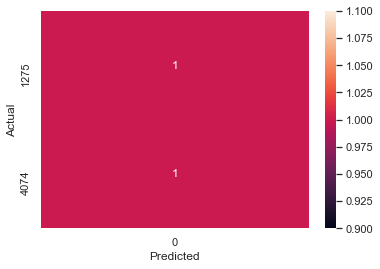

In [40]:
# plot Confusion Matrix for Naive Bayesian
df = pd.DataFrame(cmPred, columns=['y_actual', 'y_predicted'])
confusion_matrix = pd.crosstab(df['y_actual'], df['y_predicted'], rownames=['Actual'], colnames=['Predicted'])
sb.heatmap(confusion_matrix, annot=True)
plt.show()

### 5. KNN Model

In [41]:
movies_df = pd.read_csv('C:/movielens_20m/movie.csv')
ratings_df = pd.read_csv('C:/movielens_20m/rating.csv')

In [42]:
movie = movies_df.loc[:,{"movieId","title"}]
rating = ratings_df.loc[:,{"userId","movieId","rating"}]

In [43]:
movies_ratings = pd.merge(movie,rating)
movies_ratings = movies_ratings.iloc[:1000000,:]
users_movies = movies_ratings.pivot_table(index = ["title"],columns = ["userId"],values = "rating").fillna(0)
users_movies.head(10)

userId                                 1       2       3       4       5       \
title                                                                           
Ace Ventura: When Nature Calls (1995)     0.0     0.0     0.0     3.0     0.0   
Across the Sea of Time (1995)             0.0     0.0     0.0     0.0     0.0   
Amazing Panda Adventure, The (1995)       0.0     0.0     0.0     0.0     0.0   
American President, The (1995)            0.0     0.0     0.0     0.0     5.0   
Angela (1995)                             0.0     0.0     0.0     0.0     0.0   
Angels and Insects (1995)                 0.0     0.0     0.0     0.0     0.0   
Anne Frank Remembered (1995)              0.0     0.0     0.0     0.0     0.0   
Antonia's Line (Antonia) (1995)           0.0     0.0     0.0     0.0     0.0   
Assassins (1995)                          0.0     0.0     0.0     0.0     0.0   
Babe (1995)                               0.0     0.0     0.0     0.0     0.0   

userId                                 6       7       8       10      11      \
title                                                                           
Ace Ventura: When Nature Calls (1995)     0.0     0.0     1.0     0.0     3.5   
Across the Sea of Time (1995)             0.0     0.0     0.0     0.0     0.0   
Amazing Panda Adventure, The (1995)       0.0     0.0     0.0     0.0     0.0   
American President, The (1995)            0.0     4.0     0.0     4.0     0.0   
Angela (1995)                             0.0     0.0     0.0     0.0     0.0   
Angels and Insects (1995)                 0.0     0.0     0.0     0.0     0.0   
Anne Frank Remembered (1995)              0.0     0.0     0.0     0.0     0.0   
Antonia's Line (Antonia) (1995)           0.0     0.0     0.0     0.0     0.0   
Assassins (1995)                          0.0     0.0     0.0     0.0     0.0   
Babe (1995)                               0.0     0.0     0.0     0.0     0.0   

userId                                 ...  138484  138485  138486  138487  \
title                                  ...                                   
Ace Ventura: When Nature Calls (1995)  ...     2.0     0.0     0.0     0.0   
Across the Sea of Time (1995)          ...     0.0     0.0     0.0     0.0   
Amazing Panda Adventure, The (1995)    ...     0.0     0.0     0.0     0.0   
American President, The (1995)         ...     4.0     0.0     0.0     0.0   
Angela (1995)                          ...     0.0     0.0     0.0     0.0   
Angels and Insects (1995)              ...     0.0     0.0     0.0     0.0   
Anne Frank Remembered (1995)           ...     0.0     0.0     0.0     0.0   
Antonia's Line (Antonia) (1995)        ...     0.0     0.0     0.0     0.0   
Assassins (1995)                       ...     4.0     0.0     0.0     0.0   
Babe (1995)                            ...     0.0     0.0     3.5     0.0   

userId                                 138488  138489  138490  138491  138492  \
title                                                                           
Ace Ventura: When Nature Calls (1995)     0.0     0.0     0.0     0.0     0.0   
Across the Sea of Time (1995)             0.0     0.0     0.0     0.0     0.0   
Amazing Panda Adventure, The (1995)       0.0     0.0     0.0     0.0     0.0   
American President, The (1995)            0.0     0.0     0.0     0.0     0.0   
Angela (1995)                             0.0     0.0     0.0     0.0     0.0   
Angels and Insects (1995)                 0.0     0.0     4.0     0.0     0.0   
Anne Frank Remembered (1995)              0.0     0.0     0.0     0.0     0.0   
Antonia's Line (Antonia) (1995)           0.0     0.0     3.0     0.0     0.0   
Assassins (1995)                          0.0     0.0     0.0     0.0     0.0   
Babe (1995)                               0.0     0.0     5.0     0.0     0.0   

userId                                 138493  
title                                          
Ace Ventura: When Nature Calls (1995)     4.0  


In [44]:
# Randomly generated movie.
query_index = np.random.choice(users_movies.shape[0])
print("Generated Movie is: ",users_movies.index[query_index])

Generated Movie is:  Big Green, The (1995)


In [45]:
users_movies_matrix = csr_matrix(users_movies.values)
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(users_movies_matrix)
distances, indices = model_knn.kneighbors(users_movies.iloc[query_index,:].values.reshape(1,-1), n_neighbors = 6)

In [46]:
movie = []
distance = []

for i in range(0, len(distances.flatten())):
    if i != 0:
        movie.append(users_movies.index[indices.flatten()[i]])
        distance.append(distances.flatten()[i])    

m = pd.Series(movie,name='movie')
d = pd.Series(distance,name='distance')
recommend = pd.concat([m,d], axis=1)
recommend = recommend.sort_values('distance',ascending=False)

print('Recommendations for {0}:\n'.format(users_movies.index[query_index]))
for i in range(0,recommend.shape[0]):
    print('{0}: {1}, with distance of {2}'.format(i, recommend["movie"].iloc[i], recommend["distance"].iloc[i]))

Recommendations for Big Green, The (1995):

0: Indian in the Cupboard, The (1995), with distance of 0.8201031517088161
1: It Takes Two (1995), with distance of 0.7912255066404017
2: Dunston Checks In (1996), with distance of 0.7886255236283599
3: Amazing Panda Adventure, The (1995), with distance of 0.7540806997869672
4: Tom and Huck (1995), with distance of 0.7263212579843172


In [47]:
y3_test = m
knn_pred = recommend["movie"]

#### Confusion Matrix

In [48]:
# Confusion Matrix for KNN
from sklearn.metrics import confusion_matrix
cmKNN = confusion_matrix(y3_test, knn_pred)
cmKNN

array([[0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0]], dtype=int64)

In [49]:
# Classification Report for KNN
from sklearn.metrics import classification_report
print(classification_report(y3_test, knn_pred))

                                     precision    recall  f1-score   support

Amazing Panda Adventure, The (1995)       0.00      0.00      0.00         1
           Dunston Checks In (1996)       1.00      1.00      1.00         1
 Indian in the Cupboard, The (1995)       0.00      0.00      0.00         1
                It Takes Two (1995)       0.00      0.00      0.00         1
                Tom and Huck (1995)       0.00      0.00      0.00         1

                           accuracy                           0.20         5
                          macro avg       0.20      0.20      0.20         5
                       weighted avg       0.20      0.20      0.20         5



## Clustering Algorithms

In [50]:
movies_df = pd.read_csv('C:/movielens_20m/movie.csv')
movies_df.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

In [51]:
#Using regular expressions to find the 'year'
#Specify the parantheses to avoid conflict terms with movies
movies_df['year'] = movies_df.title.str.extract('(\(\d\d\d\d\))',expand=False)

#Removing the parentheses
movies_df['year'] = movies_df.year.str.extract('(\d\d\d\d)',expand=False)

#Removing the years from the 'title' column
movies_df['title'] = movies_df.title.str.replace('(\(\d\d\d\d\))', '')

#Applying the strip function to get to clear whitespace characters
movies_df['title'] = movies_df['title'].apply(lambda x: x.strip())

movies_df.head()

movieId                        title  \
0        1                    Toy Story   
1        2                      Jumanji   
2        3             Grumpier Old Men   
3        4            Waiting to Exhale   
4        5  Father of the Bride Part II   

                                        genres  year  
0  Adventure|Animation|Children|Comedy|Fantasy  1995  
1                   Adventure|Children|Fantasy  1995  
2                               Comedy|Romance  1995  
3                         Comedy|Drama|Romance  1995  
4                                       Comedy  1995

In [52]:
# Drop the Genre column and join with each genres in each columns 
movies_genres = movies_df.drop('genres',1).join(movies_df.genres.str.get_dummies())
movies_genres.head()

movieId                        title  year  (no genres listed)  Action  \
0        1                    Toy Story  1995                   0       0   
1        2                      Jumanji  1995                   0       0   
2        3             Grumpier Old Men  1995                   0       0   
3        4            Waiting to Exhale  1995                   0       0   
4        5  Father of the Bride Part II  1995                   0       0   

   Adventure  Animation  Children  Comedy  Crime  ...  Film-Noir  Horror  \
0          1          1         1       1      0  ...          0       0   
1          1          0         1       0      0  ...          0       0   
2          0          0         0       1      0  ...          0       0   
3          0          0         0       1      0  ...          0       0   
4          0          0         0       1      0  ...          0       0   

   IMAX  Musical  Mystery  Romance  Sci-Fi  Thriller  War  Western  
0     0        0        0        0       0         0    0        0  
1     0        0        0        0       0         0    0        0  
2     0        0        0        1       0         0    0        0  
3     0        0        0        1       0         0    0        0  
4     0        0        0        0       0         0    0        0  

[5 rows x 23 columns]

In [53]:
movies_genres = movies_genres.drop(['movieId','year'], axis=1)
movies_genres

title  (no genres listed)  Action  Adventure  \
0                        Toy Story                   0       0          1   
1                          Jumanji                   0       0          1   
2                 Grumpier Old Men                   0       0          0   
3                Waiting to Exhale                   0       0          0   
4      Father of the Bride Part II                   0       0          0   
...                            ...                 ...     ...        ...   
27273        Kein Bund für's Leben                   0       0          0   
27274       Feuer, Eis & Dosenbier                   0       0          0   
27275                  The Pirates                   0       0          1   
27276                 Rentun Ruusu                   1       0          0   
27277                    Innocence                   0       0          1   

       Animation  Children  Comedy  Crime  Documentary  Drama  ...  Film-Noir  \
0              1         1       1      0            0      0  ...          0   
1              0         1       0      0            0      0  ...          0   
2              0         0       1      0            0      0  ...          0   
3              0         0       1      0            0      1  ...          0   
4              0         0       1      0            0      0  ...          0   
...          ...       ...     ...    ...          ...    ...  ...        ...   
27273          0         0       1      0            0      0  ...          0   
27274          0         0       1      0            0      0  ...          0   
27275          0         0       0      0            0      0  ...          0   
27276          0         0       0      0            0      0  ...          0   
27277          0         0       0      0            0      0  ...          0   

       Horror  IMAX  Musical  Mystery  Romance  Sci-Fi  Thriller  War  Western  
0           0     0        0        0        0       0         0    0        0  
1           0     0        0        0        0       0         0    0        0  
2           0     0        0        0        1       0         0    0        0  
3           0     0        0        0        1       0         0    0        0  
4           0     0        0        0        0       0         0    0        0  
...       ...   ...      ...      ...      ...     ...       ...  ...      ...  
27273       0     0        0        0        0       0         0    0        0  
27274       0     0        0        0        0       0         0    0        0  
27275       0     0        0        0        0       0         0    0        0  
27276       0     0        0        0        0       0         0    0        0  
27277       1     0        0        0        0       0         0    0        0  

[27278 rows x 21 columns]

### 1. KMeans Clustering

In [54]:
# KMeans Clustering
km = KMeans(n_clusters=10,random_state=42)
km.fit(movies_genres.iloc[:,1:20])

KMeans(n_clusters=10, random_state=42)

In [55]:
km.labels_

array([6, 6, 8, ..., 6, 0, 9])

In [56]:
np.unique(km.labels_,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([4593, 6982, 2415, 2503, 1743, 2418, 1348, 1791, 1375, 2110],
       dtype=int64))

In [57]:
movies_genres['kmeans_cluster_labels'] = km.labels_
movies_genres.head()

title  (no genres listed)  Action  Adventure  \
0                    Toy Story                   0       0          1   
1                      Jumanji                   0       0          1   
2             Grumpier Old Men                   0       0          0   
3            Waiting to Exhale                   0       0          0   
4  Father of the Bride Part II                   0       0          0   

   Animation  Children  Comedy  Crime  Documentary  Drama  ...  Horror  IMAX  \
0          1         1       1      0            0      0  ...       0     0   
1          0         1       0      0            0      0  ...       0     0   
2          0         0       1      0            0      0  ...       0     0   
3          0         0       1      0            0      1  ...       0     0   
4          0         0       1      0            0      0  ...       0     0   

   Musical  Mystery  Romance  Sci-Fi  Thriller  War  Western  \
0        0        0        0       0         0    0        0   
1        0        0        0       0         0    0        0   
2        0        0        1       0         0    0        0   
3        0        0        1       0         0    0        0   
4        0        0        0       0         0    0        0   

   kmeans_cluster_labels  
0                      6  
1                      6  
2                      8  
3                      3  
4                      0  

[5 rows x 22 columns]

In [58]:
movies_genres.groupby('kmeans_cluster_labels').mean()

(no genres listed)    Action  Adventure  Animation  \
kmeans_cluster_labels                                                       
0                                 0.05356  0.083388   0.041150   0.019377   
1                                 0.00000  0.067889   0.045975   0.005729   
2                                 0.00000  0.732919   0.266667   0.026915   
3                                 0.00000  0.044347   0.047143   0.006792   
4                                 0.00000  0.039587   0.029260   0.009180   
5                                 0.00000  0.000827   0.015715   0.005790   
6                                 0.00000  0.117953   0.591246   0.551187   
7                                 0.00000  0.161921   0.026801   0.005025   
8                                 0.00000  0.045091   0.066182   0.010182   
9                                 0.00000  0.094787   0.015166   0.009479   

                       Children    Comedy     Crime  Documentary     Drama  \
kmeans_cluster_labels                                                        
0                      0.033965  0.867189  0.076856     0.000871  0.000000   
1                      0.013463  0.000000  0.000000     0.002292  1.000000   
2                      0.003313  0.037681  0.142443     0.000414  0.098551   
3                      0.004395  0.295246  0.045545     0.001998  1.000000   
4                      0.022949  1.000000  0.076879     0.008606  1.000000   
5                      0.001654  0.041770  0.014061     1.000000  0.032258   
6                      0.587537  0.299703  0.012611     0.002226  0.065282   
7                      0.001117  0.040759  1.000000     0.002792  0.815745   
8                      0.020364  0.821091  0.034182     0.002182  0.000000   
9                      0.001896  0.052607  0.049763     0.000474  0.118957   

                        Fantasy  Film-Noir    Horror      IMAX   Musical  \
kmeans_cluster_labels                                                      
0                      0.027651   0.004137  0.050729  0.001306  0.060745   
1                      0.022343   0.012604  0.015182  0.002292  0.018619   
2                      0.082816   0.010352  0.012008  0.032298  0.003727   
3                      0.043548   0.008390  0.008789  0.000799  0.051538   
4                      0.030407   0.001147  0.012048  0.001147  0.032702   
5                      0.001654   0.000000  0.007444  0.011993  0.040943   
6                      0.406528   0.000742  0.007418  0.033383  0.107567   
7                      0.005583   0.091569  0.026801  0.002233  0.003908   
8                      0.056727   0.002909  0.010182  0.002909  0.124364   
9                      0.060190   0.002844  1.000000  0.004739  0.004739   

                        Mystery   Romance    Sci-Fi  Thriller       War  \
kmeans_cluster_labels                                                     
0                      0.025038  0.000000  0.036795  0.019377  0.018724   
1                      0.039817  0.000000  0.022200  0.094672  0.092953   
2                      0.085714  0.037267  0.299793  0.539959  0.045963   
3                      0.031562  1.000000  0.017579  0.037555  0.064722   
4                      0.024670  0.000000  0.016064  0.025818  0.024670   
5                      0.004136  0.002068  0.004549  0.002068  0.028950   
6                      0.025964  0.040801  0.094214  0.002226  0.016320   
7                      0.189838  0.036293  0.011167  0.501954  0.009492   
8                      0.024000  1.000000  0.024000  0.042909  0.014545   
9                      0.177251  0.016114  0.204739  0.482938  0.006635   

                        Western  
kmeans_cluster_labels            
0                      0.071631  
1                      0.013606  
2                      0.033954  
3                      0.015581  
4                      0.005164  
5                      0.000827  
6                      0.025964  
7                      0.010050  
8      

### 2. Hierarchical Clustering

In [59]:
# Hierarchical clustering (bottom-up)
# Create 10 clusters
model = hclust(affinity="euclidean",linkage="ward",n_clusters=10)

In [60]:
model.fit(movies_genres.iloc[:,1:20])

AgglomerativeClustering(n_clusters=10)

In [61]:
model.n_clusters

10

In [62]:
# Label on 10 clusters
model.labels_

array([8, 8, 0, ..., 3, 3, 3], dtype=int64)

In [63]:
# label each data points wih range 0-9
len(model.labels_)

27278

In [64]:
# Numbering for the data points in each cluster
np.unique(model.labels_,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),
 array([3717, 4507, 2566, 3561, 2260, 2276, 1119, 4579, 1418, 1275],
       dtype=int64))

In [65]:
Z = ward(movies_genres.iloc[:,1:20],)
Z

array([[0.00000000e+00, 2.20900000e+03, 0.00000000e+00, 2.00000000e+00],
       [1.00000000e+00, 5.50000000e+01, 0.00000000e+00, 2.00000000e+00],
       [2.00000000e+00, 6.00000000e+00, 0.00000000e+00, 2.00000000e+00],
       ...,
       [5.45480000e+04, 5.45500000e+04, 7.36846321e+01, 1.67780000e+04],
       [5.44940000e+04, 5.45520000e+04, 7.56281686e+01, 1.90540000e+04],
       [5.45510000e+04, 5.45530000e+04, 8.86680290e+01, 2.72780000e+04]])

In [66]:
# make the column to shows cluster label for each genre
movies_genres['hclust_label'] = model.labels_
movies_genres

title  (no genres listed)  Action  Adventure  \
0                        Toy Story                   0       0          1   
1                          Jumanji                   0       0          1   
2                 Grumpier Old Men                   0       0          0   
3                Waiting to Exhale                   0       0          0   
4      Father of the Bride Part II                   0       0          0   
...                            ...                 ...     ...        ...   
27273        Kein Bund für's Leben                   0       0          0   
27274       Feuer, Eis & Dosenbier                   0       0          0   
27275                  The Pirates                   0       0          1   
27276                 Rentun Ruusu                   1       0          0   
27277                    Innocence                   0       0          1   

       Animation  Children  Comedy  Crime  Documentary  Drama  ...  IMAX  \
0              1         1       1      0            0      0  ...     0   
1              0         1       0      0            0      0  ...     0   
2              0         0       1      0            0      0  ...     0   
3              0         0       1      0            0      1  ...     0   
4              0         0       1      0            0      0  ...     0   
...          ...       ...     ...    ...          ...    ...  ...   ...   
27273          0         0       1      0            0      0  ...     0   
27274          0         0       1      0            0      0  ...     0   
27275          0         0       0      0            0      0  ...     0   
27276          0         0       0      0            0      0  ...     0   
27277          0         0       0      0            0      0  ...     0   

       Musical  Mystery  Romance  Sci-Fi  Thriller  War  Western  \
0            0        0        0       0         0    0        0   
1            0        0        0       0         0    0        0   
2            0        0        1       0         0    0        0   
3            0        0        1       0         0    0        0   
4            0        0        0       0         0    0        0   
...        ...      ...      ...     ...       ...  ...      ...   
27273        0        0        0       0         0    0        0   
27274        0        0        0       0         0    0        0   
27275        0        0        0       0         0    0        0   
27276        0        0        0       0         0    0        0   
27277        0        0        0       0         0    0        0   

       kmeans_cluster_labels  hclust_label  
0                          6             8  
1                          6             8  
2                          8             0  
3                          3             0  
4                          0             1  
...                      ...           ...  
27273                      0             1  
27274                      0             1  
27275                      6             3  
27276                      0             3  
27277                      9             3  

[27278 rows x 23 columns]

In [67]:
movies_genres.groupby(by='hclust_label').mean()

(no genres listed)    Action  Adventure  Animation  Children  \
hclust_label                                                                 
0                       0.000000  0.012645   0.006726   0.001883  0.005919   
1                       0.000000  0.079432   0.001775   0.002219  0.002441   
2                       0.000000  0.414263   0.014809   0.000390  0.000000   
3                       0.069082  0.362258   0.444538   0.030048  0.037068   
4                       0.000000  0.049115   0.013274   0.004425  0.001327   
5                       0.000000  0.003515   0.000439   0.000000  0.000000   
6                       0.000000  0.247542   0.138517   0.017873  0.000894   
7                       0.000000  0.000000   0.000000   0.000000  0.000000   
8                       0.000000  0.114951   0.331453   0.610719  0.679126   
9                       0.000000  0.159216   0.014902   0.004706  0.005490   

                Comedy     Crime  Documentary     Drama   Fantasy  ...  \
hclust_label                                                       ...   
0             0.506322  0.055152     0.000269  0.605058  0.012645  ...   
1             0.998669  0.117373     0.000000  0.330819  0.000222  ...   
2             0.016368  0.710834     0.014030  0.679657  0.001559  ...   
3             0.213142  0.047178     0.012918  0.264532  0.261724  ...   
4             0.052212  0.079646     0.004425  0.485398  0.003982  ...   
5             0.050967  0.000000     1.000000  0.045255  0.000000  ...   
6             0.098302  0.015192     0.060769  0.755139  0.000894  ...   
7             0.000000  0.000000     0.000000  1.000000  0.000000  ...   
8             0.424542  0.009873     0.011989  0.186883  0.204513  ...   
9             0.191373  0.001569     0.013333  0.022745  0.100392  ...   

                Horror      IMAX   Musical   Mystery   Romance    Sci-Fi  \
hclust_label                                                               
0             0.019370  0.000538  0.192628  0.029325  0.882701  0.005112   
1             0.012425  0.000000  0.003994  0.014644  0.000888  0.004659   
2             0.054560  0.003118  0.001949  0.089634  0.064302  0.004287   
3             0.039596  0.034260  0.001966  0.037349  0.112328  0.308060   
4             0.395133  0.001327  0.001327  0.420796  0.004425  0.059735   
5             0.000439  0.011424  0.043058  0.000000  0.005272  0.004833   
6             0.013405  0.000000  0.003575  0.001787  0.159071  0.018767   
7             0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
8             0.014810  0.019746  0.129760  0.014810  0.054302  0.093794   
9             0.997647  0.005490  0.000784  0.001569  0.000000  0.231373   

              Thriller       War   Western  kmeans_cluster_labels  
hclust_label                                                       
0             0.051386  0.003497  0.022868               4.417541  
1             0.064122  0.000444  0.018860               1.527624  
2             0.483632  0.001949  0.023772               5.144973  
3             0.143780  0.008425  0.091828               2.559113  
4             0.733628  0.005310  0.004425               4.361504  
5             0.004833  0.003954  0.000439               4.964411  
6             0.074173  0.999106  0.024129               1.967828  
7             0.000000  0.000000  0.012885               1.000000  
8             0.007757  0.003526  0.011283               4.380818  
9             0.142745  0.000000  0.003922               7.238431  

[10 rows x 21 columns]

In [68]:
# Show for comedy clusters
movies_genres[movies_genres.hclust_label==1].head()

title  (no genres listed)  Action  Adventure  \
4      Father of the Bride Part II                   0       0          0   
17                      Four Rooms                   0       0          0   
18  Ace Ventura: When Nature Calls                   0       0          0   
19                     Money Train                   0       1          0   
20                      Get Shorty                   0       0          0   

    Animation  Children  Comedy  Crime  Documentary  Drama  ...  IMAX  \
4           0         0       1      0            0      0  ...     0   
17          0         0       1      0            0      0  ...     0   
18          0         0       1      0            0      0  ...     0   
19          0         0       1      1            0      1  ...     0   
20          0         0       1      1            0      0  ...     0   

    Musical  Mystery  Romance  Sci-Fi  Thriller  War  Western  \
4         0        0        0       0         0    0        0   
17        0        0        0       0         0    0        0   
18        0        0        0       0         0    0        0   
19        0        0        0       0         1    0        0   
20        0        0        0       0         1    0        0   

    kmeans_cluster_labels  hclust_label  
4                       0             1  
17                      0             1  
18                      0             1  
19                      7             1  
20                      0             1  

[5 rows x 23 columns]

In [69]:
# Show for comedy clusters
movies_genres[movies_genres.hclust_label==2].head(10)

title  (no genres listed)  Action  \
5                                            Heat                   0       1   
14                               Cutthroat Island                   0       1   
15                                         Casino                   0       0   
21                                        Copycat                   0       0   
22                                      Assassins                   0       1   
29  Shanghai Triad (Yao a yao yao dao waipo qiao)                   0       0   
35                               Dead Man Walking                   0       0   
41                                Dead Presidents                   0       1   
49                            Usual Suspects, The                   0       0   
50                                 Guardian Angel                   0       1   

    Adventure  Animation  Children  Comedy  Crime  Documentary  Drama  ...  \
5           0          0         0       0      1            0      0  ...   
14          1          0         0       0      0            0      0  ...   
15          0          0         0       0      1            0      1  ...   
21          0          0         0       0      1            0      1  ...   
22          0          0         0       0      1            0      0  ...   
29          0          0         0       0      1            0      1  ...   
35          0          0         0       0      1            0      1  ...   
41          0          0         0       0      1            0      1  ...   
49          0          0         0       0      1            0      0  ...   
50          0          0         0       0      0            0      1  ...   

    IMAX  Musical  Mystery  Romance  Sci-Fi  Thriller  War  Western  \
5      0        0        0        0       0         1    0        0   
14     0        0        0        1       0         0    0        0   
15     0        0        0        0       0         0    0        0   
21     0        0        1        0       0         1    0        0   
22     0        0        0        0       0         1    0        0   
29     0        0        0        0       0         0    0        0   
35     0        0        0        0       0         0    0        0   
41     0        0        0        0       0         0    0        0   
49     0        0        1        0       0         1    0        0   
50     0        0        0        0       0         1    0        0   

    kmeans_cluster_labels  hclust_label  
5                       2             2  
14                      2             2  
15                      7             2  
21                      7             2  
22                      2             2  
29                      7             2  
35                      7             2  
41                      7             2  
49                      7             2  
50                      2             2  

[10 rows x 23 columns]

In [70]:
# To find a movie from itemset that similar with identified movie
# Example: toy story
# The result shows the movie is in the 8th of hclust_label and 6th kmeans_cluster_labels 
movies_genres[movies_genres.title.str.match("toy story",case=False)] 

title  (no genres listed)  Action  \
0                               Toy Story                   0       0   
3027                          Toy Story 2                   0       0   
15401                         Toy Story 3                   0       0   
21981                 Toy Story of Terror                   0       0   
24458  Toy Story Toons: Hawaiian Vacation                   0       0   
24460          Toy Story Toons: Small Fry                   0       0   
25461    Toy Story Toons: Partysaurus Rex                   0       0   
25463          Toy Story That Time Forgot                   0       0   

       Adventure  Animation  Children  Comedy  Crime  Documentary  Drama  ...  \
0              1          1         1       1      0            0      0  ...   
3027           1          1         1       1      0            0      0  ...   
15401          1          1         1       1      0            0      0  ...   
21981          0          1         1       1      0            0      0  ...   
24458          1          1         1       1      0            0      0  ...   
24460          1          1         1       1      0            0      0  ...   
25461          0          1         1       1      0            0      0  ...   
25463          0          1         1       0      0            0      0  ...   

       IMAX  Musical  Mystery  Romance  Sci-Fi  Thriller  War  Western  \
0         0        0        0        0       0         0    0        0   
3027      0        0        0        0       0         0    0        0   
15401     1        0        0        0       0         0    0        0   
21981     0        0        0        0       0         0    0        0   
24458     0        0        0        0       0         0    0        0   
24460     0        0        0        0       0         0    0        0   
25461     0        0        0        0       0         0    0        0   
25463     0        0        0        0       0         0    0        0   

       kmeans_cluster_labels  hclust_label  
0                          6             8  
3027                       6             8  
15401                      6             8  
21981                      6             8  
24458                      6             8  
24460                      6             8  
25461                      6             8  
25463                      6             8  

[8 rows x 23 columns]

In [71]:
# To show the the cluster 8 in Hierachical clustering 
movies_genres[movies_genres["hclust_label"]==8].head(10) 

title  (no genres listed)  Action  Adventure  Animation  \
0                 Toy Story                   0       0          1          1   
1                   Jumanji                   0       0          1          0   
7              Tom and Huck                   0       0          1          0   
12                    Balto                   0       0          1          1   
26             Now and Then                   0       0          0          0   
33                     Babe                   0       0          0          0   
37             It Takes Two                   0       0          0          0   
47               Pocahontas                   0       0          0          1   
53           Big Green, The                   0       0          0          0   
55  Kids of the Round Table                   0       0          1          0   

    Children  Comedy  Crime  Documentary  Drama  ...  IMAX  Musical  Mystery  \
0          1       1      0            0      0  ...     0        0        0   
1          1       0      0            0      0  ...     0        0        0   
7          1       0      0            0      0  ...     0        0        0   
12         1       0      0            0      0  ...     0        0        0   
26         1       0      0            0      1  ...     0        0        0   
33         1       0      0            0      1  ...     0        0        0   
37         1       1      0            0      0  ...     0        0        0   
47         1       0      0            0      1  ...     0        1        0   
53         1       1      0            0      0  ...     0        0        0   
55         1       0      0            0      0  ...     0        0        0   

    Romance  Sci-Fi  Thriller  War  Western  kmeans_cluster_labels  \
0         0       0         0    0        0                      6   
1         0       0         0    0        0                      6   
7         0       0         0    0        0                      6   
12        0       0         0    0        0                      6   
26        0       0         0    0        0                      1   
33        0       0         0    0        0                      1   
37        0       0         0    0        0                      0   
47        1       0         0    0        0                      3   
53        0       0         0    0        0                      0   
55        0       0         0    0        0                      6   

    hclust_label  
0              8  
1              8  
7              8  
12             8  
26             8  
33             8  
37             8  
47             8  
53             8  
55             8  

[10 rows x 23 columns]

In [72]:
# To show the the cluster 6 in KMeans
movies_genres[movies_genres["kmeans_cluster_labels"]==6].head(10) 

title  (no genres listed)  Action  Adventure  \
0                       Toy Story                   0       0          1   
1                         Jumanji                   0       0          1   
7                    Tom and Huck                   0       0          1   
12                          Balto                   0       0          1   
55        Kids of the Round Table                   0       0          1   
59    Indian in the Cupboard, The                   0       0          1   
105        Muppet Treasure Island                   0       0          1   
124    NeverEnding Story III, The                   0       0          1   
144  Amazing Panda Adventure, The                   0       0          1   
156                        Casper                   0       0          1   

     Animation  Children  Comedy  Crime  Documentary  Drama  ...  IMAX  \
0            1         1       1      0            0      0  ...     0   
1            0         1       0      0            0      0  ...     0   
7            0         1       0      0            0      0  ...     0   
12           1         1       0      0            0      0  ...     0   
55           0         1       0      0            0      0  ...     0   
59           0         1       0      0            0      0  ...     0   
105          0         1       1      0            0      0  ...     0   
124          0         1       0      0            0      0  ...     0   
144          0         1       0      0            0      0  ...     0   
156          0         1       0      0            0      0  ...     0   

     Musical  Mystery  Romance  Sci-Fi  Thriller  War  Western  \
0          0        0        0       0         0    0        0   
1          0        0        0       0         0    0        0   
7          0        0        0       0         0    0        0   
12         0        0        0       0         0    0        0   
55         0        0        0       0         0    0        0   
59         0        0        0       0         0    0        0   
105        1        0        0       0         0    0        0   
124        0        0        0       0         0    0        0   
144        0        0        0       0         0    0        0   
156        0        0        0       0         0    0        0   

     kmeans_cluster_labels  hclust_label  
0                        6             8  
1                        6             8  
7                        6             8  
12                       6             8  
55                       6             8  
59                       6             8  
105                      6             8  
124                      6             8  
144                      6             8  
156                      6             8  

[10 rows x 23 columns]

## Association Rules 

In [73]:
movies_df = pd.read_csv('C:/movielens_20m/movie.csv')
movies_df.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

In [74]:
# Drop the Genre column and join with each genres in each columns 
movies_genres = movies_df.drop('genres',1).join(movies_df.genres.str.get_dummies())
movies_genres.set_index(['movieId','title'],inplace=True)
movies_genres.head()

(no genres listed)  Action  \
movieId title                                                            
1       Toy Story (1995)                                     0       0   
2       Jumanji (1995)                                       0       0   
3       Grumpier Old Men (1995)                              0       0   
4       Waiting to Exhale (1995)                             0       0   
5       Father of the Bride Part II (1995)                   0       0   

                                            Adventure  Animation  Children  \
movieId title                                                                
1       Toy Story (1995)                            1          1         1   
2       Jumanji (1995)                              1          0         1   
3       Grumpier Old Men (1995)                     0          0         0   
4       Waiting to Exhale (1995)                    0          0         0   
5       Father of the Bride Part II (1995)          0          0         0   

                                            Comedy  Crime  Documentary  Drama  \
movieId title                                                                   
1       Toy Story (1995)                         1      0            0      0   
2       Jumanji (1995)                           0      0            0      0   
3       Grumpier Old Men (1995)                  1      0            0      0   
4       Waiting to Exhale (1995)                 1      0            0      1   
5       Father of the Bride Part II (1995)       1      0            0      0   

                                            Fantasy  Film-Noir  Horror  IMAX  \
movieId title                                                                  
1       Toy Story (1995)                          1          0       0     0   
2       Jumanji (1995)                            1          0       0     0   
3       Grumpier Old Men (1995)                   0          0       0     0   
4       Waiting to Exhale (1995)                  0          0       0     0   
5       Father of the Bride Part II (1995)        0          0       0     0   

                                            Musical  Mystery  Romance  Sci-Fi  \
movieId title                                                                   
1       Toy Story (1995)                          0        0        0       0   
2       Jumanji (1995)                            0        0        0       0   
3       Grumpier Old Men (1995)                   0        0        1       0   
4       Waiting to Exhale (1995)                  0        0        1       0   
5       Father of the Bride Part II (1995)        0        0        0       0   

                                            Thriller  War  Western  
movieId title                                                       
1       Toy Story (1995)                           0    0        0  
2       Jumanji (1995)                             0    0        0  
3       Grumpier Old Men (1995)                    0    0        0  
4       Waiting to Exhale (1995)                   0    0        0  
5       Father of the Bride Part II (1995)         0    0        0

In [75]:
#Assiociation rules
movies_genres2 = movies_df.drop(['movieId','genres','title'],1).join(movies_df.genres.str.get_dummies())
movies_genres2.head()

(no genres listed)  Action  Adventure  Animation  Children  Comedy  Crime  \
0                   0       0          1          1         1       1      0   
1                   0       0          1          0         1       0      0   
2                   0       0          0          0         0       1      0   
3                   0       0          0          0         0       1      0   
4                   0       0          0          0         0       1      0   

   Documentary  Drama  Fantasy  Film-Noir  Horror  IMAX  Musical  Mystery  \
0            0      0        1          0       0     0        0        0   
1            0      0        1          0       0     0        0        0   
2            0      0        0          0       0     0        0        0   
3            0      1        0          0       0     0        0        0   
4            0      0        0          0       0     0        0        0   

   Romance  Sci-Fi  Thriller  War  Western  
0        0       0         0    0        0  
1        0       0         0    0        0  
2        1       0         0    0        0  
3        1       0         0    0        0  
4        0       0         0    0        0

In [76]:
#itemset retrieval and filtering the results
frequent_itemsets = apriori(movies_genres, min_support = 0.02, use_colnames=True)

# To compute the no.of items inside a movie
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets.head(10)

support       itemsets  length
0  0.129042       (Action)       1
1  0.085380    (Adventure)       1
2  0.037649    (Animation)       1
3  0.041755     (Children)       1
4  0.306987       (Comedy)       1
5  0.107743        (Crime)       1
6  0.090586  (Documentary)       1
7  0.489185        (Drama)       1
8  0.051763      (Fantasy)       1
9  0.095718       (Horror)       1

In [77]:
# For itemset with length = 1, support >= 8%
frequent_itemsets[ (frequent_itemsets['length'] == 2) & (frequent_itemsets['support'] >= 0.08) ]

support          itemsets  length
26  0.093335   (Drama, Comedy)       2
31  0.094325  (Drama, Romance)       2

In [78]:
# For itemset with length = 2, support >= 5%
frequent_itemsets[ (frequent_itemsets['length'] == 2) & (frequent_itemsets['support'] >= 0.05) ]

support           itemsets  length
26  0.093335    (Drama, Comedy)       2
27  0.069470  (Romance, Comedy)       2
28  0.062761     (Drama, Crime)       2
31  0.094325   (Drama, Romance)       2
32  0.068480  (Drama, Thriller)       2

In [79]:
# For itemset with length = 3, support >= 4%
frequent_itemsets[ (frequent_itemsets['length'] == 3) & (frequent_itemsets['support'] >= 0.01) ]

support                  itemsets  length
36  0.027458  (Drama, Romance, Comedy)       3
37  0.024965  (Drama, Thriller, Crime)       3

In [80]:
# The sample for querying the genres of an itemset
frequent_itemsets[ frequent_itemsets['itemsets'] == {'Action', 'Adventure'} ]

support             itemsets  length
17  0.035633  (Adventure, Action)       2

In [81]:
frequent_itemsets[ frequent_itemsets['itemsets'] == {'Comedy', 'Romance'} ]

support           itemsets  length
27  0.06947  (Romance, Comedy)       2

In [82]:
frequent_itemsets[ frequent_itemsets['itemsets'] == {'Drama'} ]

support itemsets  length
7  0.489185  (Drama)       1